In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.6 MB/s eta 0:00:00


In [2]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
# from torchvision.models import resnet50, swin_v2_b
from transformers import AutoFeatureExtractor, AutoImageProcessor, ViTForImageClassification

# Fine-Tuning with a Pre-Trained Vision Transformer
<!-- - Freeze all layers of the pre-trained model as a feature extractor -->
- Train a new classification head by combining a `nn.Linear` and `nn.Softmax`

In [3]:
torch.manual_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Ingestion

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# root_path = "/content/drive/Othercomputers/My MacBook Pro 2021/Documents/ai-image-detection/root"
# root_path = "/content/drive/Othercomputers/My MacBook Pro 2021/Documents/Cornell/CS 5787/CS 5787 - Final Project/data/root"
root_path = "/content/drive/MyDrive/CS 5787 - Final Project/data/root"

In [6]:
def load_dalle(feature_extractor, BATCH_SIZE):

    # AutoFeatureExtractor
    def transform(image):
        return feature_extractor(image, return_tensors='pt')['pixel_values'].squeeze()
    
    ds = torchvision.datasets.ImageFolder(root=root_path, transform=transform)

    # 80/20 train-test split
    ds_train, ds_test = torch.utils.data.random_split(ds, lengths=[round(0.8 * len(ds)), round(0.2 * len(ds))])

    # DataLoaders: loads and shuffles the training dataset in mini-batches
    train_loader = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=2)
    
    return ds, train_loader, test_loader

In [7]:
# Load dataset
ds, train_loader, test_loader = load_dalle(AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224"), 64)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [8]:
class_counts = pd.Series(ds.targets).value_counts().to_frame('n_samples')
class_counts['class'] = class_counts.index.map({k:v for v, k in ds.class_to_idx.items()})
class_counts

,n_samples,class
0,1000,class_control
1,1000,class_dalle
2,1000,class_midjourney
3,1000,class_stable_diffusion


## Model Initialization

Create a hook to save the output of the last hidden layer (in this case linear layer)

In [9]:
from transformers import SwinModel

In [10]:
modelSwin = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
modelSwin = modelSwin.to(DEVICE)

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Transfer Learning

In [11]:
def count_trainable_params(model):
  # count params
  total_num_trainable_params = 0
  total_num_frozen_params = 0
  for name, params in model.named_parameters():
    num_params = params.numel()
    if params.requires_grad:
      print('Trainable', name, num_params)
      total_num_trainable_params += num_params
    else:
      print('Frozen', name, num_params)
      total_num_frozen_params += num_params
    # print(name, '\t', num_params)

  print('Total num trainable params:', total_num_trainable_params)
  print('Total num frozen params:', total_num_frozen_params)

# freeze param
def freeze_all_but_top_layer(model):
  for name, params in model.named_parameters():
    if name.startswith('embeddings'):
      # disable embedder gradients
      print('freezing', name)
      params.requires_grad = False
    if name.startswith('encoder.layers.0.'):
      print('freezing', name)
      # disable stage 0 gradients
      params.requires_grad = False
    if name.startswith('encoder.layers.1.'):
      print('freezing', name)
      # disable stage 1 gradients
      params.requires_grad = False
    if name.startswith('encoder.layers.2.'):
      print('freezing', name)
      # disable stage 2 gradients
      params.requires_grad = False
    if name.startswith('encoder.layers.3.blocks.0'):
      print('freezing', name)
      # disable stage 2 gradients
      params.requires_grad = False      
  return model

In [12]:
modelSwin = freeze_all_but_top_layer(modelSwin)
print("-------------------------------------------------------------")
count_trainable_params(modelSwin)

freezing embeddings.patch_embeddings.projection.weight
freezing embeddings.patch_embeddings.projection.bias
freezing embeddings.norm.weight
freezing embeddings.norm.bias
freezing encoder.layers.0.blocks.0.layernorm_before.weight
freezing encoder.layers.0.blocks.0.layernorm_before.bias
freezing encoder.layers.0.blocks.0.attention.self.relative_position_bias_table
freezing encoder.layers.0.blocks.0.attention.self.query.weight
freezing encoder.layers.0.blocks.0.attention.self.query.bias
freezing encoder.layers.0.blocks.0.attention.self.key.weight
freezing encoder.layers.0.blocks.0.attention.self.key.bias
freezing encoder.layers.0.blocks.0.attention.self.value.weight
freezing encoder.layers.0.blocks.0.attention.self.value.bias
freezing encoder.layers.0.blocks.0.attention.output.dense.weight
freezing encoder.layers.0.blocks.0.attention.output.dense.bias
freezing encoder.layers.0.blocks.0.layernorm_after.weight
freezing encoder.layers.0.blocks.0.layernorm_after.bias
freezing encoder.layers.0

In [13]:
# Create a class with up to final linear layer
# Add a linear and softmax
class AiImageDetector(nn.Module):

    def __init__(self, model, freeze_input_model_layers=True):
        
        super().__init__()

        # Create a class with up to final linear layer
        self.pipeline = model

        # Freeze the Swin model
        if freeze_input_model_layers:
            for param in self.pipeline.parameters():
                param.requires_grad = False
        
        # Classifier layer that actually trained
        self.clf = nn.Sequential(
            nn.Linear(768, 4),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.pipeline(x)['pooler_output']
        # x = torch.flatten(x, 1)
        x = self.clf(x)

        return x

### Training

In [14]:
def train_classifier(model, N_EPOCHS = 50):

    # Initialize the model, optimizer, and loss function
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    # Training loop
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(DEVICE)
    train_loss_list = []

    for epoch in range(N_EPOCHS):
        train_loss = 0.0
        for images, labels in tqdm(train_loader):
            # Move the images and labels to the device (GPU or CPU) that the model is being trained on.
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            # clear gradients before each new backward pass
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            # Compute cost
            loss = loss_fn(outputs, labels)
            # Backward pass to upgdate gradients with autograd
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Avg. training loss for the epoch
        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)
        print(f'Epoch {epoch + 1}/{N_EPOCHS} || Loss: {train_loss:.6f}')
    
    return train_loss_list

In [15]:
def plot_train_loss(train_loss_list):
    # Plot training loss
    plt.plot(train_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('TRAINING LOSS AS FUNCTION OF EPOCHS')
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/30 || Loss: 0.944914


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/30 || Loss: 0.821990


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/30 || Loss: 0.802844


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/30 || Loss: 0.807177


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/30 || Loss: 0.790200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/30 || Loss: 0.772846


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/30 || Loss: 0.772526


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/30 || Loss: 0.778446


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/30 || Loss: 0.779796


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/30 || Loss: 0.782461


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/30 || Loss: 0.798568


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/30 || Loss: 0.791417


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/30 || Loss: 0.777993


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/30 || Loss: 0.772782


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/30 || Loss: 0.775548


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/30 || Loss: 0.783003


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/30 || Loss: 0.788930


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/30 || Loss: 0.775564


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/30 || Loss: 0.763810


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/30 || Loss: 0.758554


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/30 || Loss: 0.757199


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/30 || Loss: 0.754683


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/30 || Loss: 0.753209


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/30 || Loss: 0.754704


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/30 || Loss: 0.758410


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/30 || Loss: 0.759371


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/30 || Loss: 0.757619


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/30 || Loss: 0.770680


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/30 || Loss: 0.760465


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30/30 || Loss: 0.764581


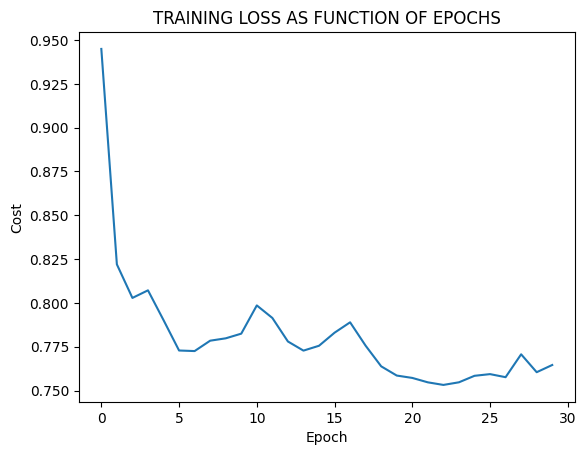

In [16]:
model = AiImageDetector(modelSwin, freeze_input_model_layers=False)
model_loss = train_classifier(model, N_EPOCHS=30)
plot_train_loss(model_loss)


torch.save(model, '/'.join(root_path.split('/')[:-1]) + "/swin_finetune_unfreeze_Stage3Block1.pt")

### Testing

In [17]:
def test_classifier(model, test_loader):
    correct = 0
    total = 0
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    y_test = []
    y_pred = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)

            # Store y_test and y_pred
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_test.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'TEST DATA ACCURACY: {test_accuracy:.2f}%')

    return np.array(y_test), np.array(y_pred)

In [18]:
#@title
# TRAINING DATA ACCURACY
y_train, y_pred = test_classifier(model, train_loader)

  0%|          | 0/50 [00:00<?, ?it/s]

TEST DATA ACCURACY: 98.38%


In [19]:
#@title
y_test, y_pred = test_classifier(model, test_loader)

  0%|          | 0/13 [00:00<?, ?it/s]

TEST DATA ACCURACY: 91.75%


### Evaluation

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [21]:
class_counts

,n_samples,class
0,1000,class_control
1,1000,class_dalle
2,1000,class_midjourney
3,1000,class_stable_diffusion


In [22]:
print(classification_report(y_test, y_pred))
print("Mean-per-class accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       220
           1       0.91      0.90      0.91       188
           2       0.91      0.92      0.91       192
           3       0.88      0.91      0.89       200

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.92       800
weighted avg       0.92      0.92      0.92       800

Mean-per-class accuracy: 0.9175


Text(0.5, 1.0, 'Confusion Matrix: Swin Transformer')

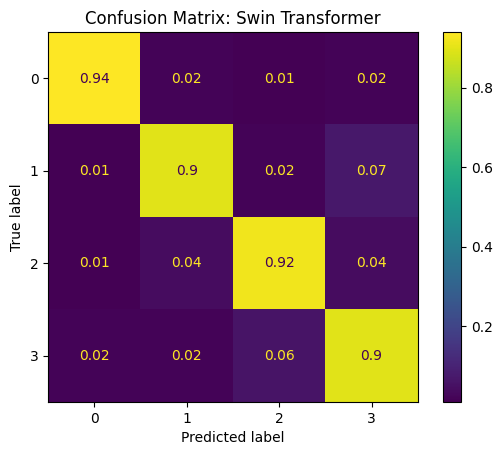

In [23]:
cm = np.round((confusion_matrix(y_test, y_pred, normalize = "true")),2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix: Swin Transformer')